## HMM EXAMPLES 

In [1]:
# do all the imports
try:
  import pyspch
except:
  ! pip install git+https://github.com/compi1234/pyspch.git

%matplotlib inline    
import sys, os,time
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from pyspch import libhmm 
from pyspch import Densities

# print all variable statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# graphical and print preferences
cmap_1 = sns.light_palette("caramel",50,input="xkcd")
cmap_2 = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap_3 = sns.light_palette("caramel",50,input="xkcd")[25:50]
cmap = cmap_2
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
#mpl.rcParams['ps.papersize'] = 'A4'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
    column-width: 60px;
    color: black !important;
}

## Example (1) 

Our HMM example is graphically shown in the drawing below

<img src="hmm_diagram_2.png">

The HMM parameters consist of **initial probabilities** and **transition probabilities** .
In the notebook we enter these in the matrices **imat**, **tmat**    

The observation model is captured by a discrete density model parametrized with **emission probabilities**.   
In this example we use a single feature and a single matrix is passed to the feature_probs for initialization.

#### (a) The Observation Model of the HMM

In [4]:
emat = np.array([[.7,.3],[.1, .9],[.6,.4]])
dd1 = Densities.Discrete(feature_probs=[emat],labels=[np.array(['A','B'])],classes=np.array(['S0','S1','S2']) )
print("\nDiscrete Density Observation Model\n")
dd1.print_model()


Discrete Density Observation Model

++ Feature (0) ++
 


,S0,S1,S2
P(A|.),0.700,0.100,0.600
P(B|.),0.300,0.900,0.400


#### (b) The state Model of the HMM

In [5]:
imat = np.array([1.0, 0.0, 0.])
tmat = np.array([[.6,.4,0.],[0.,.5,.5],[0.,0.,1.]]) 
hmm1 = libhmm.HMM(n_states=3,prob_style="lin",obs_model=dd1,
                  transmat=tmat,initmat=imat)
hmm1.print_model()


HMM STATE MODEL



,S0,S1,S2
Pinit(.),1.000,0.000,0.000


,S0,S1,S2
P(S0|.),0.600,0.000,0.000
P(S1|.),0.400,0.500,0.000
P(S2|.),0.000,0.500,1.000



OBSERVATION MODEL

++ Feature (0) ++
 


,S0,S1,S2
P(A|.),0.700,0.100,0.600
P(B|.),0.300,0.900,0.400


#### (c) An Observation Stream
Compute the Observation Probabilities for the Observation Sequence

In [6]:
Xl=np.array(['A','B','B','A','B']).reshape(-1,1)
X = dd1.lbl2indx(Xl)
obs_probs = dd1.predict_prob(X)

print("OBSERVATION LABELS\n")
pd.DataFrame(Xl.T)
print("OBSERVATIONS (INDICES)\n")
pd.DataFrame(X.T) 

print("OBSERVATION PROBABILITIES\n")
pd.DataFrame(obs_probs.T,index=dd1.classes_) 

OBSERVATION LABELS



,0,1,2,3,4
0,A,B,B,A,B


OBSERVATIONS (INDICES)



,0,1,2,3,4
0,0,1,1,0,1


OBSERVATION PROBABILITIES



,0,1,2,3,4
S0,0.700,0.300,0.300,0.700,0.300
S1,0.100,0.900,0.900,0.100,0.900
S2,0.600,0.400,0.400,0.600,0.400


## Trellis Computations:
### 1. Forward Pass Probabilities  (Viterbi, Forward Algorithm)

The **TRELLIS** is a matrix structure of shape (n_states,n_samples) containing in *cell (i,t)* the probability of being in *state S_i* at time *t*

(note: strictly speaking in a discrete density model we have observation *probabilities* and in a continuous density model we work with *observation likelihoods*; when talking about the general case we may use the terms probabilities/likelihoods in a loose way)

With *forward pass* we indicate that the Trellis is composed in left-to-right fashion, i.e. a trellis cell contains the probability after having observerd *all observations up to X_t*.  When working with an existing HMM we typically only need a forward pass.
( A *backward pass* (working from last frame till current) is only needed in the forward-backward training algorithm for HMMs. )

It is standard and efficient to fill a Trellis  in a left-to-right *time synchronous* way, i.e. all cells (\*,t) are computed as soon as observation X(t) becomes available and for first order Markov models only knowledge of the current observation and the previous column of the trellis is required.

Hence the trellis computations are simple recursions (coming in 2 flavors):
- **Viterbi Probability** (computes the probability along the most likely path, it is typically used for decoding/recognition and alignment)
$ P(i,t) = \max_j P(j,t-1) * P(j,i) * P(X(t)|i) $   

- **Forward Probability** (computes the "true" probability, is mainly used in training HMMs with the Forward-Backward algorithm)  
$ P(i,t) = \sum_j P(j,t-1) * P(j,i) * P(X(t)|i) $

Note:
- In both cases the sum- or max-operators need to be applied over all possible states that have a transition leading into *State S_i*
- The *state likelihoods* P(X(t)|i) are the likelihood of observing X(t) in State i (also called emmission likelihood)
- We further need some initialization probabilities, that tell us the probability of starting in a State with the first observation, so that we can start the recursion

The left-to-right recursive implementation is illustrated below for the basic example using **Viterbi**:
- the trellis is the main matrix structure
- the annotations above the matrix contain both the label of the observation and the state likelihoods

In [7]:
tr = libhmm.Trellis(hmm1)
tr.viterbi_pass(X.reshape(-1,1))
tr.obs_probs.T, tr.probs.T, tr.backptrs.T

(array([[0.7, 0.3, 0.3, 0.7, 0.3],
        [0.1, 0.9, 0.9, 0.1, 0.9],
        [0.6, 0.4, 0.4, 0.6, 0.4]]),
 array([[0.7       , 0.126     , 0.02268   , 0.0095256 , 0.00171461],
        [0.        , 0.252     , 0.1134    , 0.00567   , 0.00342922],
        [0.        , 0.        , 0.0504    , 0.03402   , 0.013608  ]]),
 array([[ 0,  0,  0,  0,  0],
        [ 1,  0,  1,  1,  0],
        [ 2, -1,  1,  1,  2]]))

### 2. COMPLETION and BACKTRACING

+ a. COMPLETION   
The probability of the full observation being generated by the underlying HMM is found in final column of the Trellis.
We just need to look for the highest scoring cell amongst all states that are admissible ending states.
E.g. in a left-to-right model as the one under consideration we implicitly assume that the we need to end in the final state.

+ b. BACKPOINTERS and BACKTRACKING  
Often we are not only interested in the probability that our observation has for the model, but we may also want to know which states have been traversed (e.g. when we do speech recognition and states are phonemes or words).  In such situation we need to find the state alignment that underlies the best path.  This will only be possible when applying the **Viterbi** algorithm and when maintaining  **backpointers of the full trellis**.  During the forward path computations we add a backpointers in each cell: i.e. we mark the state from which we entered the current state to give us the max probability.   

Finally, when we have completed the Trellis, we can do backtracking from the final state following the backpointers all the way to the initial frame.


In [8]:
print("Key results for Viterbi Pass\n================================")
print("Sequence Probability: %.4f \nEnd-state: %d" %(tr.seq_prob,tr.end_state))
print("Alignment:",tr.hmm.states[tr.backtrace()])

Key results for Viterbi Pass
Sequence Probability: 0.0136 
End-state: 2
Alignment: ['S0' 'S1' 'S1' 'S2' 'S2']


In [9]:
tr.print_trellis(X=Xl)


Observations



,0,1,2,3,4
X,A,B,B,A,B



Observation Probabilities



,0,1,2,3,4
S0,0.700,0.300,0.300,0.700,0.300
S1,0.100,0.900,0.900,0.100,0.900
S2,0.600,0.400,0.400,0.600,0.400



Trellis Probabilities (Viterbi)



,0,1,2,3,4
S0,0.700,0.126,0.023,0.010,0.002
S1,0.000,0.252,0.113,0.006,0.003
S2,0.000,0.000,0.050,0.034,0.014



Alignment



,0,1,2,3,4
X,A,B,B,A,B
VIT-ALIGN,S0,S1,S1,S2,S2



Sequence Probability: 1.36e-02



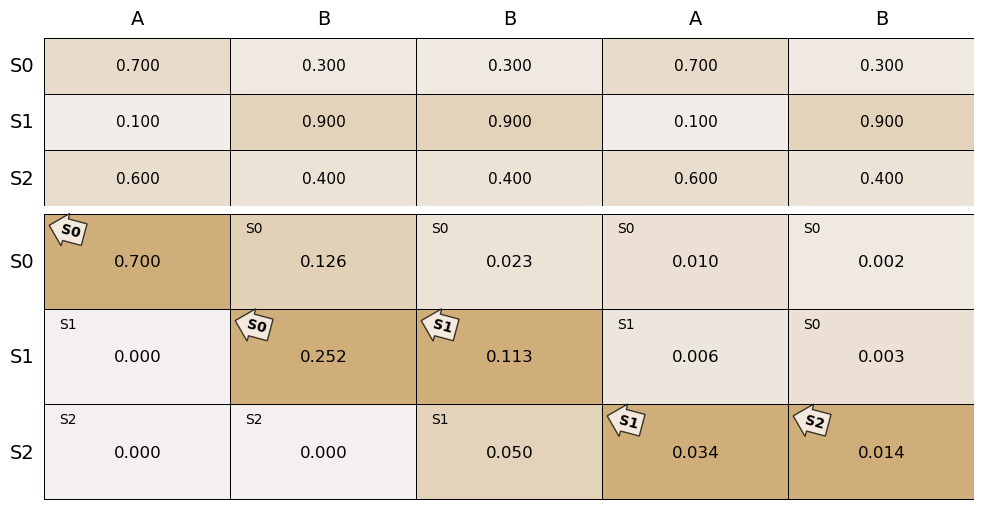

In [10]:
tr.plot_trellis(xticks=Xl.flatten(),plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,cmap=cmap_1,vmin=0.,vmax=2,cmapf=cmap_2)

### 3. Forward Algorithm Example

In [11]:
tr2 = libhmm.Trellis(hmm1,style='Forward')
tr2.forward_pass(X.reshape(-1,1))
tr2.print_trellis()


Observation Probabilities



,0,1,2,3,4
S0,0.700,0.300,0.300,0.700,0.300
S1,0.100,0.900,0.900,0.100,0.900
S2,0.600,0.400,0.400,0.600,0.400



Trellis Probabilities (Forward)



,0,1,2,3,4
S0,0.700,0.126,0.023,0.010,0.002
S1,0.000,0.252,0.159,0.009,0.007
S2,0.000,0.000,0.050,0.078,0.033



Sequence Probability: 3.29e-02



## Example 2: Multi-D Discrete Features

This example matches the 2D example in the course notes, but uses a somewhat different transition model and uses only one 'sil' state for alignment (actually allowing repeats)

In [12]:
em1 = np.array( [ [ .05,.1,.85], [.1,.75,.15], [.5,.3,.2], [.2,.4,.4] ] )
em2 = np.array( [ [.9,.1], [.7,.3], [.1,.9], [.9,.1] ] )
dd2 = Densities.Discrete(feature_probs=[em1,em2],
                   labels=[['H','M','L'],['U','V']],
                   classes=[ 'sil', 'm', 'iy', 's'])

dd2.print_model()

++ Feature (0) ++
 


,sil,m,iy,s
P(H|.),0.050,0.100,0.500,0.200
P(M|.),0.100,0.750,0.300,0.400
P(L|.),0.850,0.150,0.200,0.400


++ Feature (1) ++
 


,sil,m,iy,s
P(U|.),0.900,0.700,0.100,0.900
P(V|.),0.100,0.300,0.900,0.100


In [13]:
imat = np.array([1.0, 0.0, 0.0, 0.0])
tmat = np.array([[.8,.2,0.,0.],[0.,.8,.2,0.],[0.,0.,.8,.2],[.2,0.,0.,.8]]) 
hmm2 = libhmm.HMM(n_states=4,prob_style="lin",obs_model=dd2,
                  transmat=tmat,initmat=imat)
hmm2.print_model()


HMM STATE MODEL



,sil,m,iy,s
Pinit(.),1.000,0.000,0.000,0.000


,sil,m,iy,s
P(sil|.),0.800,0.000,0.000,0.200
P(m|.),0.200,0.800,0.000,0.000
P(iy|.),0.000,0.200,0.800,0.000
P(s|.),0.000,0.000,0.200,0.800



OBSERVATION MODEL

++ Feature (0) ++
 


,sil,m,iy,s
P(H|.),0.050,0.100,0.500,0.200
P(M|.),0.100,0.750,0.300,0.400
P(L|.),0.850,0.150,0.200,0.400


++ Feature (1) ++
 


,sil,m,iy,s
P(U|.),0.900,0.700,0.100,0.900
P(V|.),0.100,0.300,0.900,0.100


In [14]:
hmm2.__dict__

{'_Debug': False,
 'prob_style': 'lin',
 'prob_floor': 1e-39,
 'obs_model': <pyspch.Densities.Discrete at 0x7fefc00ccb50>,
 'states': array(['sil', 'm', 'iy', 's'], dtype='<U3'),
 'n_states': 4,
 'transmat': array([[0.8, 0.2, 0. , 0. ],
        [0. , 0.8, 0.2, 0. ],
        [0. , 0. , 0.8, 0.2],
        [0.2, 0. , 0. , 0.8]]),
 'initmat': array([1., 0., 0., 0.]),
 'end_states': array([0, 1, 2, 3])}

In [15]:
X2l = np.array( [ ['L','U'], ['M','U'], ['L','V'], ['M','U'], 
            ['L','U'], ['H','V'], ['H','V'],['M','V'],['M','U'] ,['L','U']])
X2 = dd2.lbl2indx(X2l)
X2.T

array([[2, 1, 2, 1, 2, 0, 0, 1, 1, 2],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 0]], dtype=int32)

In [16]:
# force finalization in SIL
hmm2.end_states = np.array([0])
# the Normalize flag normalizes the max observation probability in each frame to 1.
tr = libhmm.Trellis(hmm2,Normalize=True)
tr.viterbi_pass(X2)
tr.obs_probs.T, tr.probs.T, tr.backptrs.T

(array([[0.765, 0.09 , 0.085, 0.09 , 0.765, 0.005, 0.005, 0.01 , 0.09 ,
         0.765],
        [0.105, 0.525, 0.045, 0.525, 0.105, 0.03 , 0.03 , 0.225, 0.525,
         0.105],
        [0.02 , 0.03 , 0.18 , 0.03 , 0.02 , 0.45 , 0.45 , 0.27 , 0.03 ,
         0.02 ],
        [0.36 , 0.36 , 0.04 , 0.36 , 0.36 , 0.02 , 0.02 , 0.04 , 0.36 ,
         0.36 ]]),
 array([[1.00000000e+00, 6.85714286e-01, 1.00000000e+00, 2.22040816e-01,
         1.00000000e+00, 7.18989310e-02, 7.98877011e-04, 1.02880658e-04,
         9.25925926e-03, 5.31250000e-01],
        [0.00000000e+00, 1.00000000e+00, 7.72058824e-01, 1.00000000e+00,
         6.18151672e-01, 2.66666667e-01, 1.77777778e-02, 1.48148148e-02,
         8.64197531e-02, 2.52057613e-02],
        [0.00000000e+00, 0.00000000e+00, 7.72058824e-01, 5.71428571e-02,
         2.94357939e-02, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         3.33333333e-01, 1.85185185e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.71428571e-01,
     

/Users/Shared/anaconda3/envs/py37_x/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


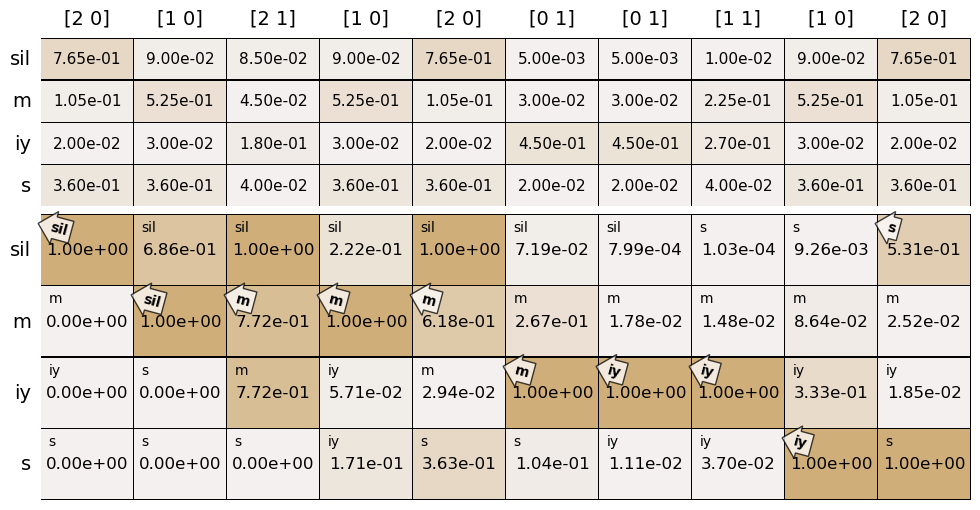

In [17]:
tr.plot_trellis(xticks=X2,plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,cmap=cmap_1,vmin=0.,vmax=2,cmapf=cmap_2,fmt=".2e")

In [18]:
print("Alignment\n")
pd.DataFrame(tr.hmm.states[tr.backtrace()]).T 
print("Sequence Likelihood: %.3e" % tr.seq_prob)
print("Trellis scale in final column: %.3e" % tr.scale)

Alignment



,0,1,2,3,4,5,6,7,8,9
0,sil,m,m,m,m,iy,iy,iy,s,sil


Sequence Likelihood: 7.865e-09
Trellis scale in final column: 1.480e-08
